# ATL06 exploration: missing data

### When does ATL06 fail to estimate surface elevation?
- An atmospheric event is deviating photons? (e.g. clouds, snow, wind) 
- An anomalous surface process? 
- Other?

Import libraries to retrieve and plot data.

In [1]:
from utils_ATL06 import *
from utils_plots import *

In the dashboard below:
1. Select a __date range__; 
2. Select a geographical __area__ of interest by drawing a box on the map, uploading a shapefile, or defining the coordinates of a bounding box.

Then, run the cell below to obtain the corresponding ATL06 data as a Pandas dataframe.

__Note__: for this demo, cached data is only available for the time range 09/01/2019 - 15/01/2019, and for the bounding box [-50, 70, -48.5, 71].

In [2]:
area()

AppLayout(children=(VBox(children=(HTML(value='<h1>Select area (time and space)</h1>'), HBox(children=(Label(v…

__Note__: if you want to download files that are not cached, you need an [Earthdata](https://urs.earthdata.nasa.gov/users/new) account! 

In [5]:
df = atl06_data(path = "./data/new_ATL06")

The area was selected using: box corners
Available Granules: ['ATL06_20190112025232_02240205_003_01.h5', 'ATL06_20190115135914_02770203_003_01.h5']
You have already downloaded all the requested files


In [6]:
df.head()

ground_track                       time  segment_id beam_strength  \
0         gt1l 2019-01-12 02:55:35.729918      607859        strong   
1         gt1l 2019-01-12 02:55:35.732750      607860        strong   
2         gt1l 2019-01-12 02:55:35.735572      607861        strong   
3         gt1l 2019-01-12 02:55:35.738379      607862        strong   
4         gt1l 2019-01-12 02:55:35.741175      607863        strong   

   start_rgt   latitude  longitude         h_li  dh_fit_dx  dh_fit_dy  ...  \
0        224  70.773955 -48.500040  1827.285156  -0.005122   0.003542  ...   
1        224  70.773777 -48.500110  1827.167969  -0.007222   0.003350  ...   
2        224  70.773599 -48.500179  1827.094116  -0.001654   0.003608  ...   
3        224  70.773421 -48.500247  1827.010986  -0.007659   0.003483  ...   
4        224  70.773243 -48.500316  1826.882568  -0.005095   0.002445  ...   

        bsnow_h      bsnow_od  cloud_flg_asr  cloud_flg_atm  msw_flag  \
0  3.402823e+38  3.402823e+38              1              0         0   
1  3.402823e+38  3.402823e+38              1              0         0   
2  3.402823e+38  3.402823e+38              1              0         0   
3  3.402823e+38  3.402823e+38              1              0         0   
4  3.402823e+38  3.402823e+38              1              0         0   

   layer_flag  dem_flag        dem_h    geoid_h        bckgrd  
0           0         1  1828.873291  34.087246  23033.089844  
1           0         1  1828.743530  34.086849  25974.726562  
2           0         1  1828.630127  34.086464  25180.125000  
3           0         1  1828.536865  34.086094  20791.804688  
4           0         1  1828.459473  34.085690  19607.609375  

[5 rows x 26 columns]

The function `clean()` will drop all the rows for which the ATL06 algorithm failed to estimate `h_li`, and will add a `height_diff` column that captures the pointwise difference between elevation estimated by ATL06 and by ArcticDEM.

In [7]:
df_clean = clean(df)

With the `plot_daily()` function, we can pick a day, visualize ATL06 data with a map and profile view, and we can choose what information to obtain through the profiles' color. 

In [8]:
plot_daily(df_clean)

Row
    [0] Column
        [0] Markdown(str)
        [1] Select(name='day', options=[datetime.date(2019, ...], value=datetime.date(2019, ...)
        [2] Select(name='color', options=['atl06_quality_summary', ...], value='ground_track')
    [1] ParamFunction(function)

The bottom plot is endowed with a box-select option that we can use to select an area for which we would like to retrieve additional information, namely:
* ATL03 photon data 
* VIIRS imagery data on clouds
* ERA5 atmospheric data on wind strenght and surface temperature

It can be interesting to look at this additional data if we observe anomalous ATL06 profiles.

__Note__: in the next three sections we will look at ATL03, VIIRS and ERA5 data. In order to use cached data, it is necessary to first use the dashboard above to:
1. Select the day __2019-01-15__ from the drop-down list;
2. Click the __box-select__ icon on the right of the bottom plot;
3. Select the __central area__ of the bottom plot, where data is missing.

## ATL03

In [9]:
df_03 = atl03_data(df_clean,
                   path = "data/new_ATL03")

Available Granules: ['ATL03_20190115135914_02770203_003_01.h5']
You have already downloaded all the requested files


In [10]:
df_03.head()

h_ph     lon_ph     lat_ph ground_track
0  1205.959229 -49.254440  70.000004         gt1l
1  1205.867554 -49.254440  70.000004         gt1l
2  1205.691040 -49.254444  70.000016         gt1l
3  1205.914795 -49.254447  70.000022         gt1l
4  1205.963501 -49.254449  70.000029         gt1l

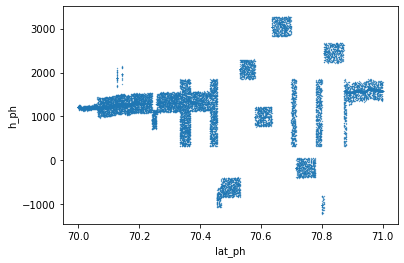

In [11]:
df_03[df_03.ground_track=='gt1l'].plot.scatter(x='lat_ph', y='h_ph', s=0.1)

Do these blocks depend on the presence of clouds?

## VIIRS cloud mask
This product, obtained from satellite imagery, offers a reliable cloud mask. 

__Note__: for this demo, you can avoid going through step 2) below, and simply run the following cells that will use cached data. 

The VIIRS retrieval entails three steps:
1) We input a bash file that we could use to download VIIRS images capturing Greenland since the launch of ICESat-2, and we only select images that fall into a user-defined time window centered around the ATL06 data time. 

In [10]:
VIIRS_select(df_clean, 
             minutes = 90, 
             max_viirs = 5, 
             path_in = "data/VIIRS_bash/VIIRS-Greenland-download.sh", 
             path_out = "data/VIIRS_bash/VIIRS-Greenland-download-filtered.sh")

>>> There are a total of 3 viirs files found out of 15890 file names.


2) We proceed to the download by running the following two commands in the terminal:

    - cd data/VIIRS_bash
    - chmod 777 VIIRS-Greenland-download-filtered.sh
    - ./VIIRS-Greenland-download-filtered.sh (asks Earthdata username and password)

3) Among the downloaded files, we keep only the ones covering the area we are interested in. The output of `VIIRS_get()` is a list of xarray datasets, each one corresponding to a VIIRS cloud mask.

In [11]:
v = VIIRS_get(df_clean, 
              path = "data/VIIRS_bash")

ATL06 data collected at 2019-01-15 14:02:37.644399
2019-01-15 13:36:00
2019-01-15 15:18:00
2 images matching area


The VIIRS integer cloud mask can have four different values:
- 0 = confident cloudy
- 1 = probably cloudy
- 2 = probably clear
- 3 = confident clear

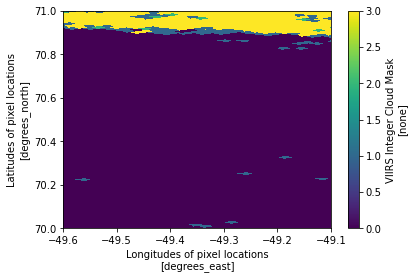

In [12]:
v[0].Integer_Cloud_Mask.plot.pcolormesh('longitude', 
                                        'latitude',
                                        xlim=(-49.6, -49.1), 
                                        ylim=(70, 71))

## ERA5 wind and temperature data

We retrieve the corresponding ERA5 data that are hosted by Amazon Web Services (AWS) in Zarr format. ERA5 is a climate reanalysis product that contains a lot of atmospheric information, available hourly. Here we will focus on wind at 10 and 100 meters from the surface, and air temperature at 2 metres.

In [12]:
plot_era5(df_clean)

Row
    [0] Column
        [0] Markdown(str)
        [1] DiscreteSlider(formatter='%d', name='Hour', options=[14, 15], value=14)
        [2] DiscreteSlider(formatter='%d', name='Wind height (meters)', options=[10, 100], value=10)
        [3] Markdown(str)
    [1] ParamFunction(function)

## ArcticDEM pointwise comparison

We can exploit the `height_diff` variable to investigate the relation between height estimated by ATL06 and by ArcticDEM. Note that `height_diff` is negative when the height estimated by ArcticDEM is larger.

In [14]:
plot_DEM_difference(df_clean)

Row
    [0] Column
        [0] Markdown(str)
        [1] Select(name='scatter', options=['segment_id', ...], value='longitude')
        [2] Select(name='histogram', options=['ground_track', ...], value='ground_track')
        [3] DataFrame(DataFrame)
    [1] ParamFunction(function)